In [34]:
import  numpy                           as np
import  pandas                          as pd
import  tensorflow                      as tf
import  matplotlib                      as mpl
import  matplotlib.pyplot               as plt
import  tensorflow.keras.backend        as K

from    sklearn.base                    import BaseEstimator, ClassifierMixin
from    sklearn.metrics                 import accuracy_score
from    sklearn.preprocessing           import MultiLabelBinarizer, LabelEncoder
from    sklearn.neural_network          import MLPClassifier
from    sklearn.model_selection         import GridSearchCV, StratifiedKFold, train_test_split

from    tensorflow.keras                import Sequential
from    tensorflow.keras.layers         import Input, Dense, Dropout
from    tensorflow.keras.callbacks      import EarlyStopping
from    tensorflow.keras.regularizers   import l2

# Set high-resolution matplotlib plots
mpl.rcParams['figure.dpi'] = 300

### **Dataset Processing**

In [35]:
# Load the dataset
df = pd.read_csv(r'./Dataset/dataset.csv')

In [36]:
symptom_cols = [c for c in df.columns if c.lower().startswith('symptom')]   #gather all the columns that have the name column
#collapse them into a single python list 
df['symptom_list'] = df[symptom_cols].apply(
    lambda row: [
        s.strip()                    # remove leading/trailing spaces If you skip it: You’d end up with duplicates in your classifier—two distinct features called "rash" vs. "rash ".
        for s in row.tolist()        # iterate over the raw values
        if isinstance(s, str)        # skip NaNs (they’re floats)  If you skip it: Your lists will include nan, and MultiLabelBinarizer will treat that as its own “symptom” category.
           and s.strip()             # drop empty strings If you skip it: You’d get "" entries in your lists, again creating bogus “empty” symptom categories
    ],
    axis=1
)

In [37]:
# 2. BINARIZE SYMPTOMS → FEATURE MATRIX X
# ----------------------------------------
mlb = MultiLabelBinarizer()      # From lecture: MultiLabelBinarizer usage...Creates an object that will learn all distinct symptom names.In the lecture, this was the “convenience wrapper” to turn lists of labels into multi-hot vectors .
X = mlb.fit_transform(df['symptom_list']) #with the fit function: scans every row’s list of symptoms to build its “vocabulary” of unique symptom features (columns)....
                                        #transform :for each row, emits a binary vector of length n_symptoms, putting 1 wherever that symptom appears, 0 otherwise
print(X.shape)                           #X is an (n_samples × n_symptoms) NumPy array..this is what we are going to feed into the NNs

(4920, 131)


In [38]:
# 3. ENCODE DISEASE LABELS → TARGET y
# ------------------------------------
le    = LabelEncoder()           # From lecture: LabelEncoder usage...Assigns each distinct disease a unique integer label (0, 1, 2, …).
y_int = le.fit_transform(df['Disease']) #fit: learns the set of disease names.
                                        #transform: maps each disease string (e.g. "Fungal infection") to its integer code.
y     = tf.keras.utils.to_categorical(y_int)  # From lecture: to_categorical on labels...Converts the integer labels into one-hot vectors for multiclass softmax training.

In [39]:
# 4. SPLIT 70/30 TRAIN/TEST
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,        # 30% test → your request (lecture used 25%)
    random_state=42        # From lecture: fixed random_state
)

In [40]:
print(type(X_train), X_train.dtype, X_train.shape)
print(type(y_train), y_train.dtype, y_train.shape)
print("X_train:", type(X_train), X_train.dtype, X_train.shape)
print("y_train:", type(y_train), y_train.dtype, y_train.shape)
print("X_train.min(), max():", X_train.min(), X_train.max())
print("y_train.min(), max():", y_train.min(), y_train.max())

<class 'numpy.ndarray'> int64 (3444, 131)
<class 'numpy.ndarray'> float64 (3444, 41)
X_train: <class 'numpy.ndarray'> int64 (3444, 131)
y_train: <class 'numpy.ndarray'> float64 (3444, 41)
X_train.min(), max(): 0 1
y_train.min(), max(): 0.0 1.0


### **Neural Network**

In [41]:
# 5. BUILD KERAS SEQUENTIAL MODEL
# --------------------------------
model = Sequential([           # From lecture: Sequential([...]) pattern...Stacks layers in order
    Dense(64, activation='relu', input_dim=X.shape[1]),  # Dense + ReLU...128 hidden units, ReLU activation, expecting input vectors of length n_symptoms
    Dropout(0.5),               # From lecture: use of Dropout..Randomly zeroes 50% of units each training step to regularize.
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')  # Lecture: final Dense + activation...Outputs one score per disease class, normalized to probabilities.


])
model.summary()                 # From lecture: model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 41)             │         1,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,881 (46.41 KB)

 Trainable params: 11,881 (46.41 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# 6. COMPILE
# ------------
model.compile(
    optimizer='adam',                # From lecture: optimizer='adam'
    loss='categorical_crossentropy', # From lecture: loss='binary_crossentropy' → adapted for multiclass
    metrics=['accuracy']             # From lecture: metrics=['accuracy']
)

In [43]:
# 7. TRAIN
# ---------
history = model.fit(
    X_train, y_train,
    validation_split=0.3,    # From lecture: validation_split
    epochs=50,               # From lecture: epochs=50
    batch_size=16,           # From lecture: batch_size=16 → you can adapt
    verbose=1                # Progress bar 
)


Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0592 - loss: 3.6316 - val_accuracy: 0.7137 - val_loss: 2.8748
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.2882 - loss: 2.8407 - val_accuracy: 0.9188 - val_loss: 1.5226
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.4871 - loss: 1.9413 - val_accuracy: 0.9932 - val_loss: 0.7202
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.5705 - loss: 1.5485 - val_accuracy: 1.0000 - val_loss: 0.3682
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.6152 - loss: 1.2926 - val_accuracy: 1.0000 - val_loss: 0.2242
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.6617 - loss: 1.1163 - val_accuracy: 1.0000 - val_loss: 0.1526
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6934 - loss: 1.0514 - val_accuracy: 1.0000 - val_loss: 0.1066
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.6953 - loss: 0.9626 - va

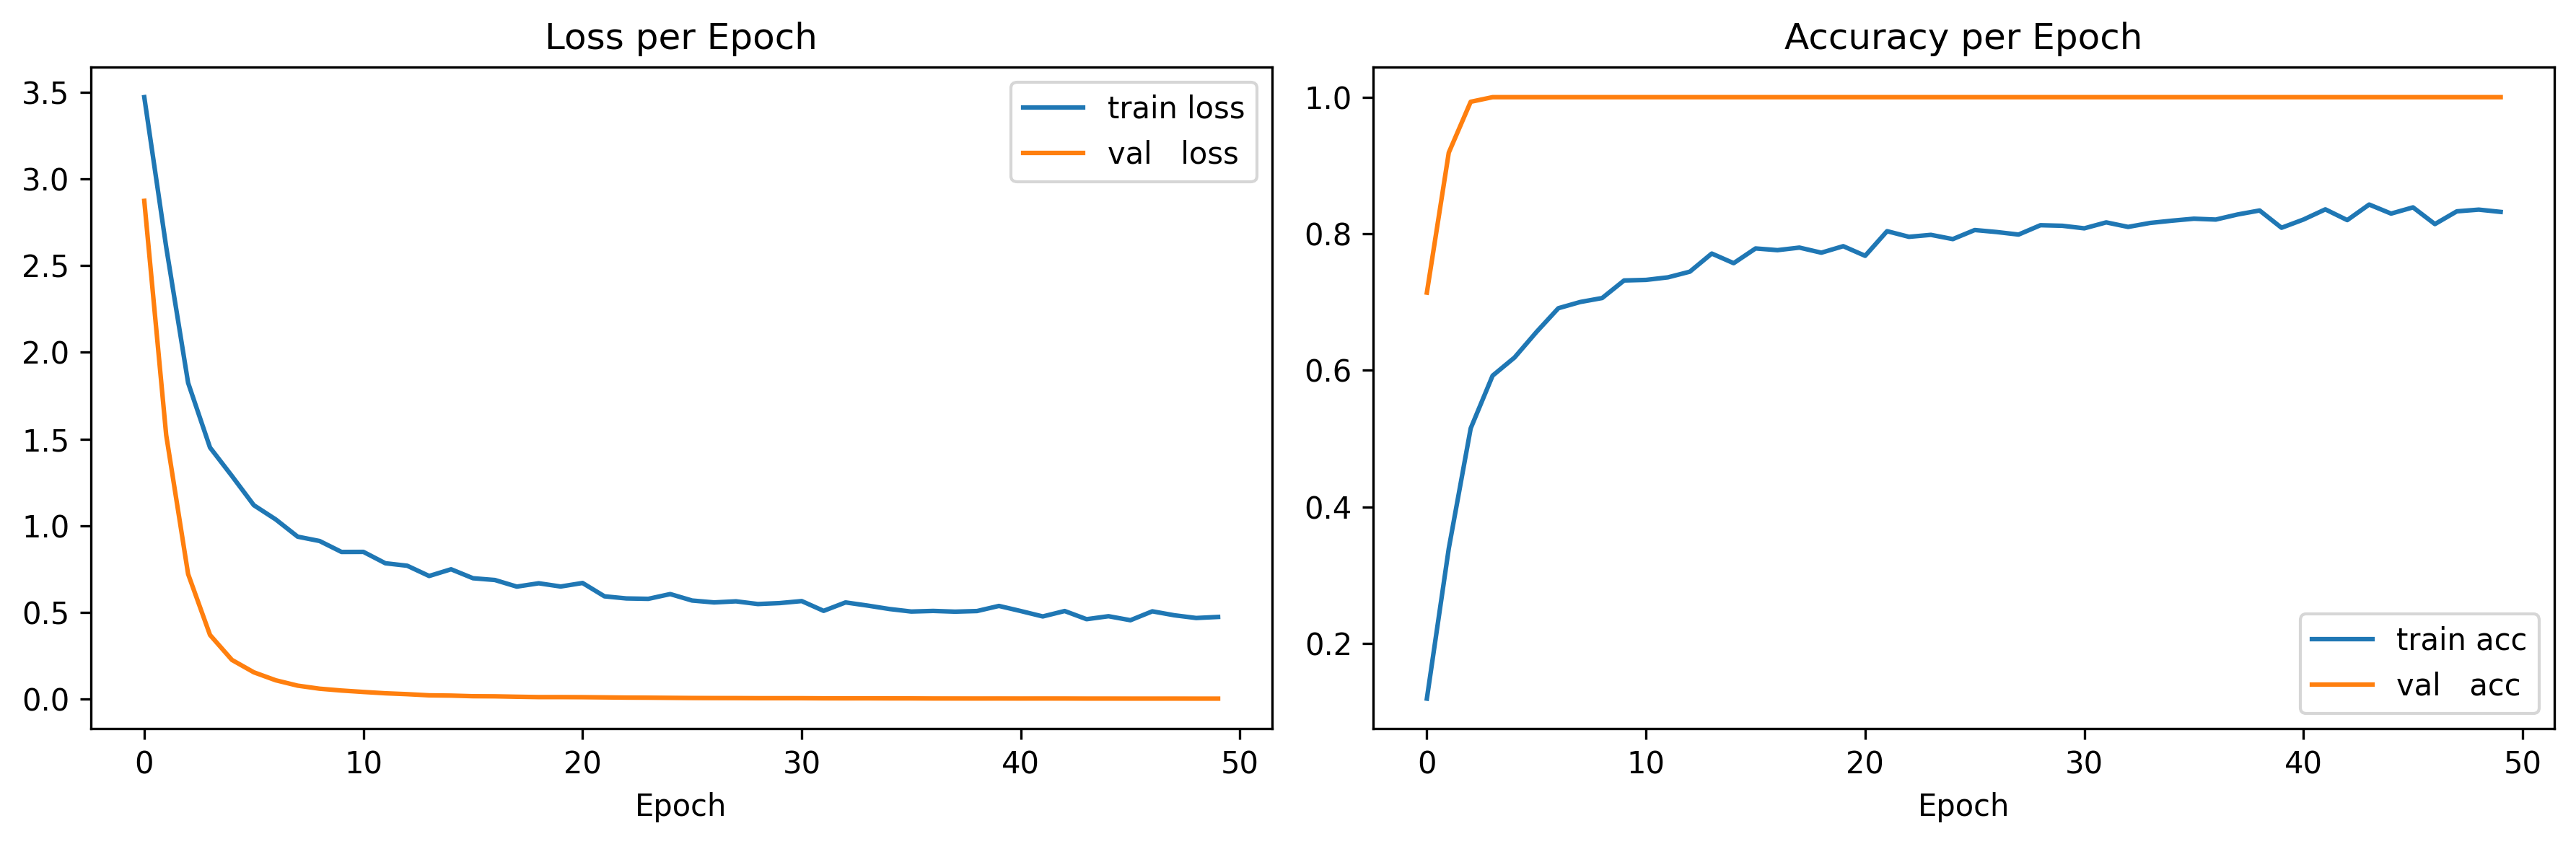

► Test loss: 0.0006   Test accuracy: 1.0000


In [44]:
# 8. PLOT LOSS & ACCURACY
# ------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],    label='train loss')      # From lecture: plotting history
plt.plot(history.history['val_loss'],label='val   loss')
plt.title('Loss per Epoch')                                   # From lecture: titles
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],    label='train acc')
plt.plot(history.history['val_accuracy'],label='val   acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()                         # From lecture: plt.show()

# 9. EVALUATE ON TEST SET
# ------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)  # From lecture: model.evaluate
print(f"► Test loss: {test_loss:.4f}   Test accuracy: {test_acc:.4f}")

### **Early Stopping**

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0627 - loss: 3.6318 - val_accuracy: 0.6538 - val_loss: 3.0017
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.2601 - loss: 2.9252 - val_accuracy: 0.9168 - val_loss: 1.6388
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.4240 - loss: 2.0939 - val_accuracy: 0.9942 - val_loss: 0.8011
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.5396 - loss: 1.6265 - val_accuracy: 1.0000 - val_loss: 0.4337
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.6093 - loss: 1.3315 - val_accuracy: 1.0000 - val_loss: 0.2368
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.6597 - loss: 1.1886 - val_accuracy: 1.0000 - val_loss: 0.1510
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.6705 - loss: 1.0443 - val_accuracy: 1.0000 - val_loss: 0.1075
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.7039 - loss: 0.9542 - va

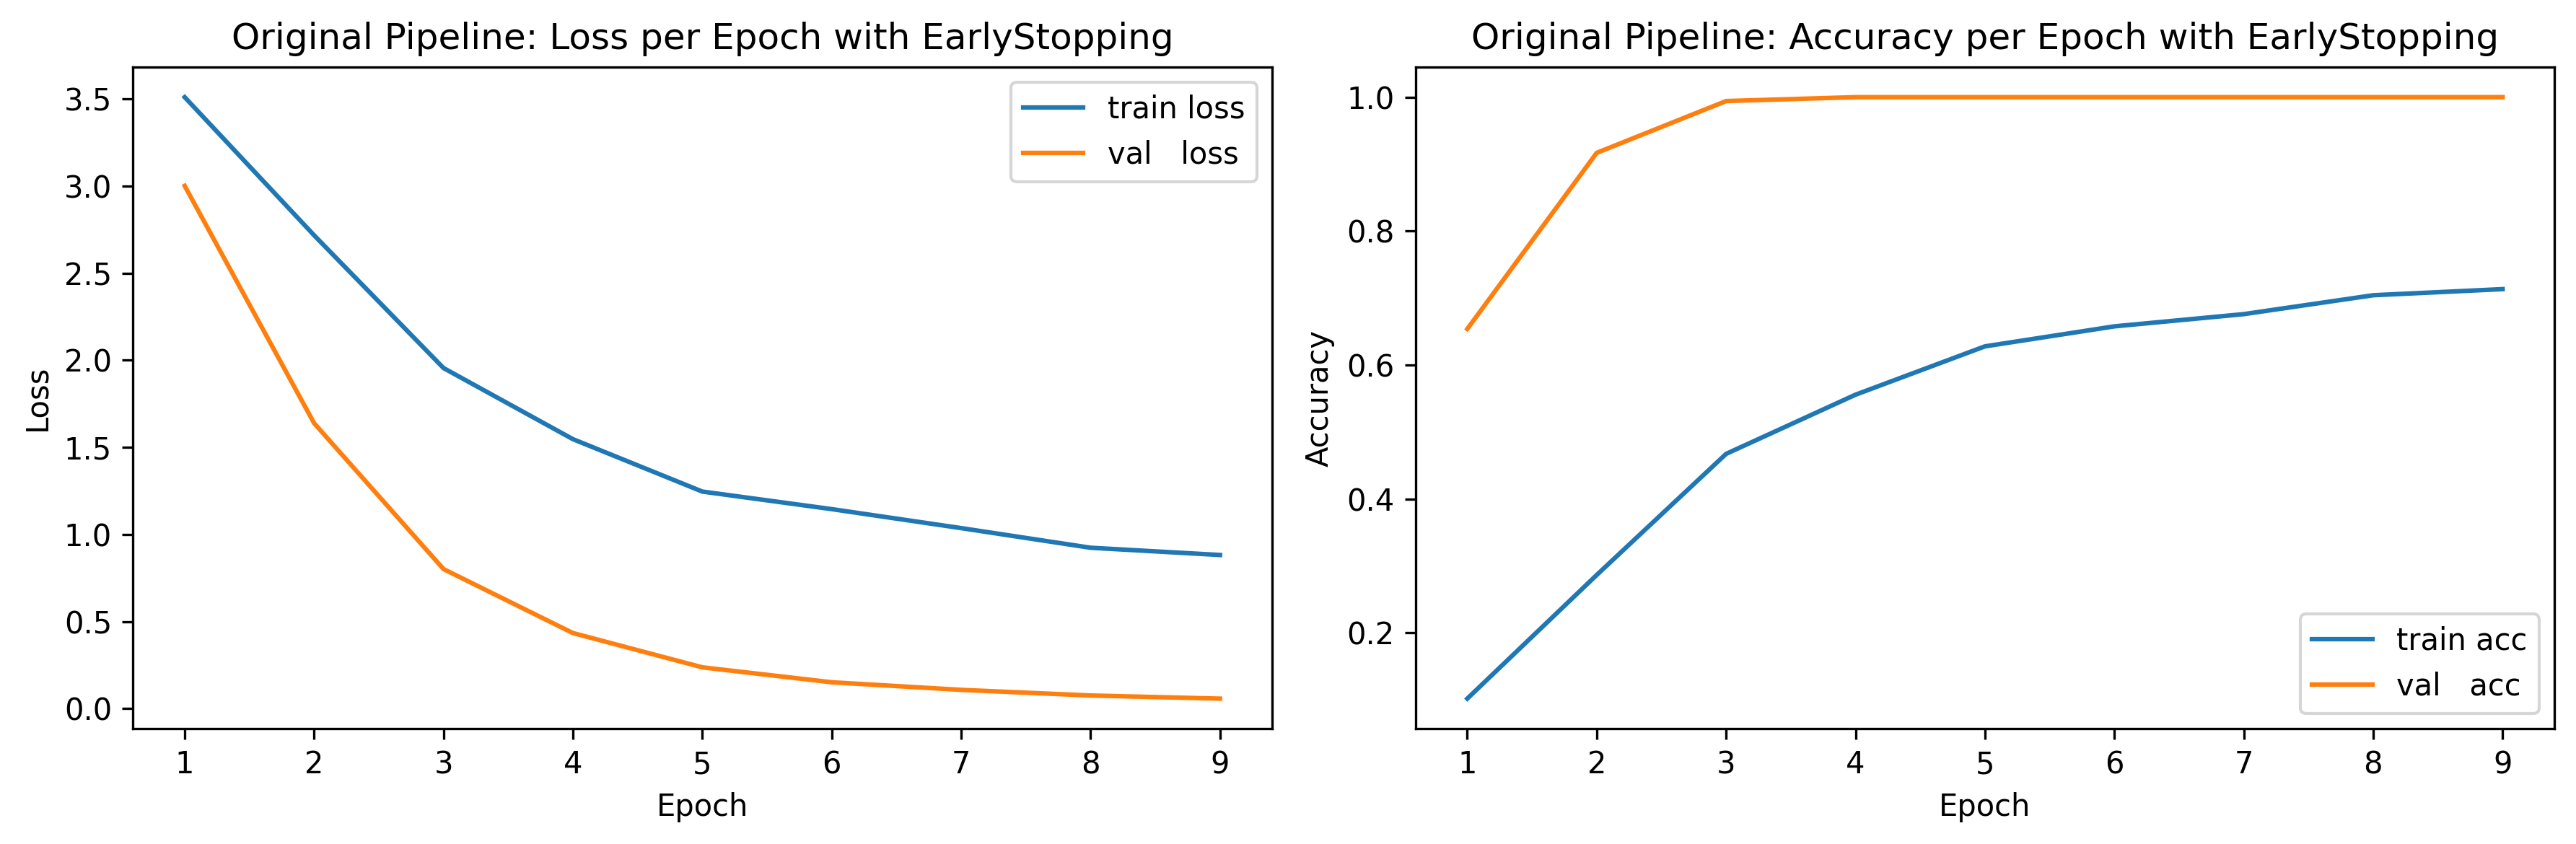

Original Test loss: 0.4356,  Test accuracy: 1.0000


In [45]:
# 1) Clear any old models/weights
K.clear_session()

# 2) Build a fresh model (no L2) on the original data
model_orig_es = Sequential([
    Input(shape=(X_train.shape[1],)),   # original feature dim (131)
    Dense(64, activation='relu'),      # same as your first pipeline
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# 3) Compile it
model_orig_es.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4) Set up EarlyStopping callback
early_orig = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# 5) Train with EarlyStopping on the original X_train/y_train
history_orig_es = model_orig_es.fit(
    X_train, y_train,
    validation_split=0.30,  # 20% of the 70% train → 14% of total
    epochs=50,
    batch_size=16,          # same as original
    callbacks=[early_orig],
    verbose=1
)

# 6) Plot the train/val curves
epochs_o = len(history_orig_es.history['loss'])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, epochs_o+1), history_orig_es.history['loss'],    label='train loss')
plt.plot(range(1, epochs_o+1), history_orig_es.history['val_loss'],label='val   loss')
plt.title('Original Pipeline: Loss per Epoch with EarlyStopping')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs_o+1), history_orig_es.history['accuracy'],    label='train acc')
plt.plot(range(1, epochs_o+1), history_orig_es.history['val_accuracy'],label='val   acc')
plt.title('Original Pipeline: Accuracy per Epoch with EarlyStopping')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# 7) Evaluate on the original hold‐out test set
test_loss_o, test_acc_o = model_orig_es.evaluate(X_test, y_test, verbose=0)
print(f"Original Test loss: {test_loss_o:.4f},  Test accuracy: {test_acc_o:.4f}")


But notice that getting 100 % val acc so quickly still isn’t a sign of true generalization—it’s the same memorization leak we’ve been chasing. Your validation split is still sampling duplicate symptom‐patterns that the network saw in training, so it can nail them perfectly in just a few passes.

### **L2 Regularization**

Epoch 1/50
151/151 - 1s - 5ms/step - accuracy: 0.0851 - loss: 4.3150 - val_accuracy: 0.4323 - val_loss: 3.7119
Epoch 2/50
151/151 - 0s - 813us/step - accuracy: 0.2324 - loss: 3.4437 - val_accuracy: 0.7795 - val_loss: 2.7659
Epoch 3/50
151/151 - 0s - 744us/step - accuracy: 0.3876 - loss: 2.8460 - val_accuracy: 0.9391 - val_loss: 2.0883
Epoch 4/50
151/151 - 0s - 690us/step - accuracy: 0.4859 - loss: 2.5101 - val_accuracy: 0.9420 - val_loss: 1.7129
Epoch 5/50
151/151 - 0s - 684us/step - accuracy: 0.5349 - loss: 2.2888 - val_accuracy: 0.9729 - val_loss: 1.4985
Epoch 6/50
151/151 - 0s - 708us/step - accuracy: 0.5606 - loss: 2.1720 - val_accuracy: 0.9971 - val_loss: 1.3340
Epoch 7/50
151/151 - 0s - 697us/step - accuracy: 0.5992 - loss: 2.0568 - val_accuracy: 0.9990 - val_loss: 1.2305
Epoch 8/50
151/151 - 0s - 688us/step - accuracy: 0.6162 - loss: 1.9905 - val_accuracy: 0.9942 - val_loss: 1.1502
Epoch 9/50
151/151 - 0s - 701us/step - accuracy: 0.6332 - loss: 1.9307 - val_accuracy: 1.0000 - va

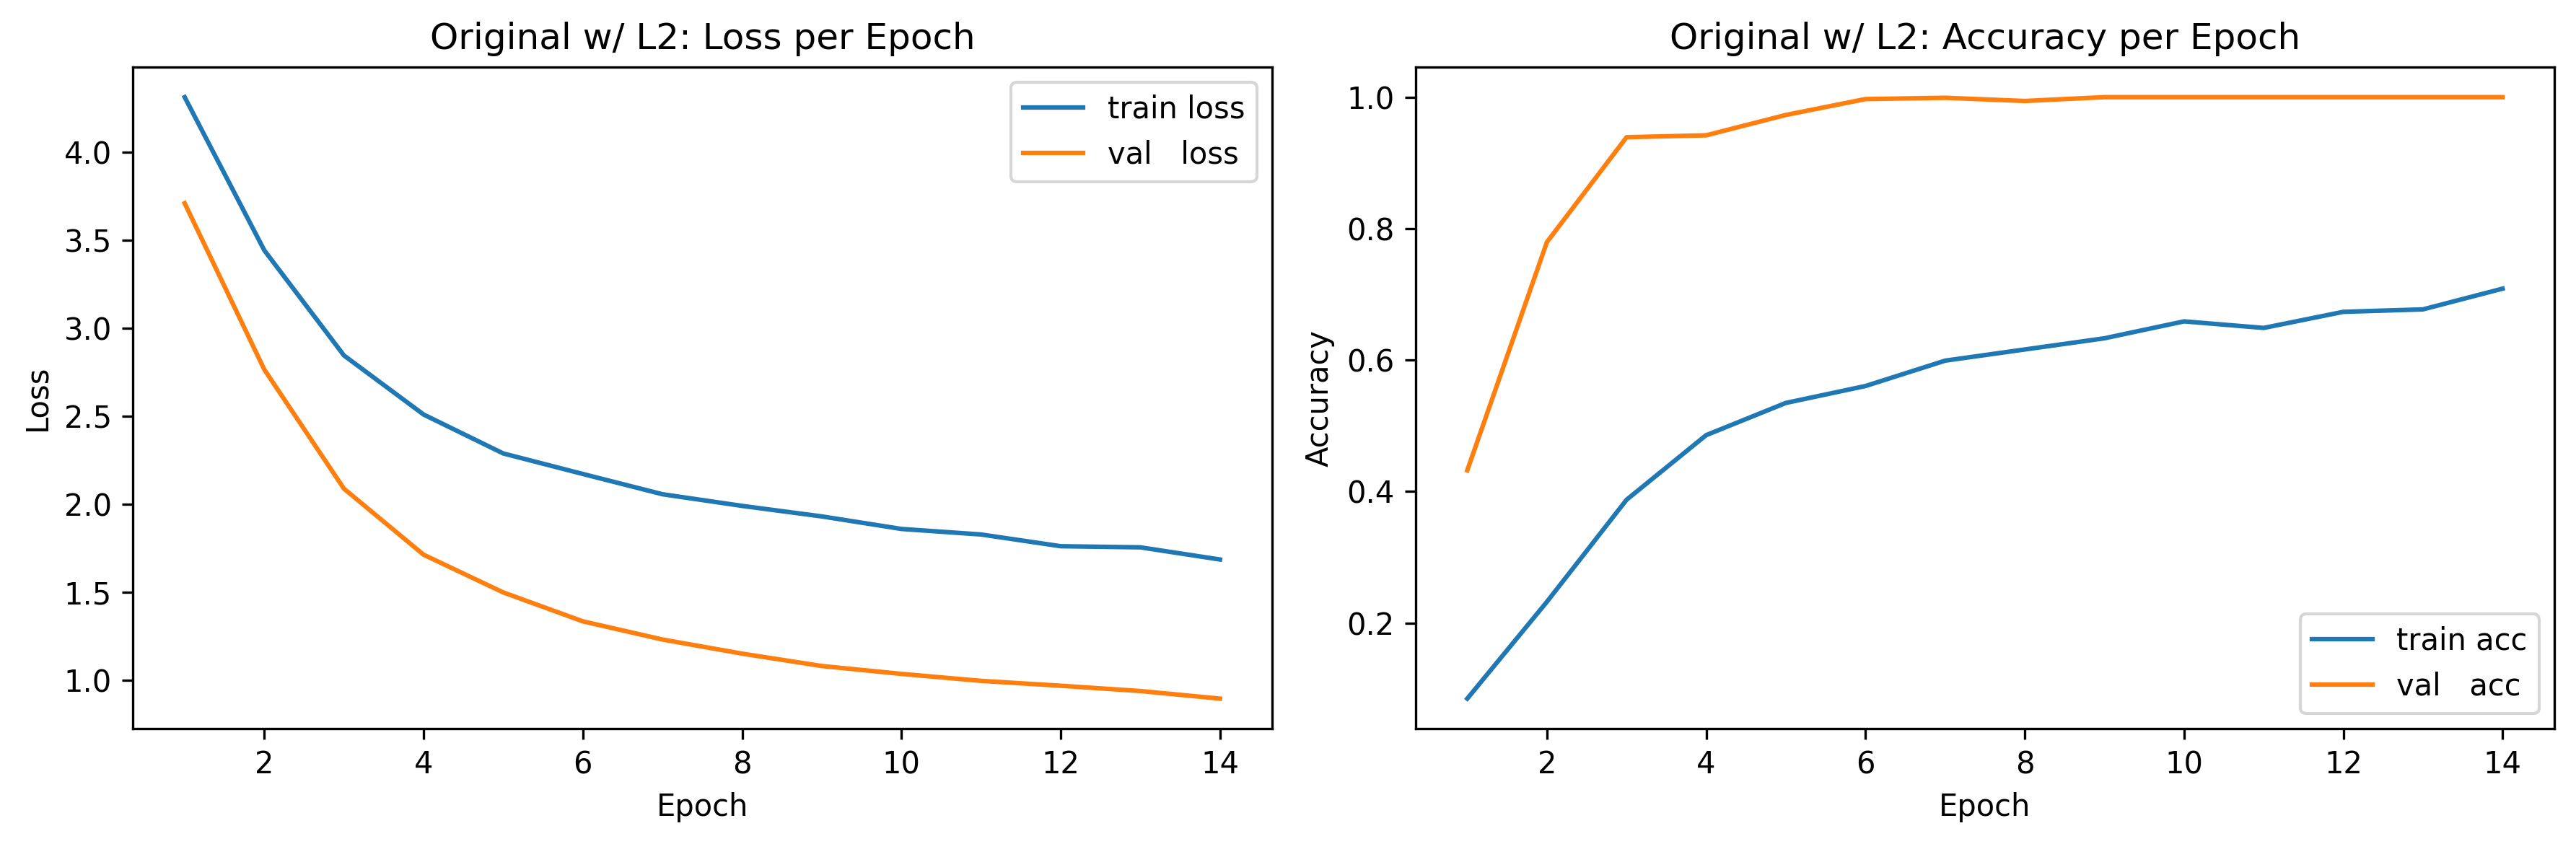

 Original + L2 Test loss: 1.0805,  Test accuracy: 1.0000


In [46]:
# ─── Clear any old TF state ───
K.clear_session()

# ─── 1) Build a fresh model with L2 on both Dense layers ───
model_orig_l2 = Sequential([
    Input(shape=(X_train.shape[1],)),                       # original 131‐dim input
    Dense(64, activation='relu',
          kernel_regularizer=l2(0.01)),                     # L2 λ=0.01 (lecture)
    Dropout(0.5),
    Dense(32, activation='relu',
          kernel_regularizer=l2(0.01)),                     # L2 on second layer
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')           # 41‐way softmax
])

# ─── 2) Compile ───
model_orig_l2.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# ─── 3) EarlyStopping callback (as before) ───
early_l2 = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    restore_best_weights=True
)

# ─── 4) Train ───
history_orig_l2 = model_orig_l2.fit(
    X_train, y_train,
    validation_split=0.30,   # 20% of the 70% train
    epochs=50,               # up to 50 epochs
    batch_size=16,           # same as original
    callbacks=[early_l2],    # now with L2 + EarlyStopping
    verbose=2
)

# ─── 5) Plot Loss & Accuracy ───
import matplotlib.pyplot as plt
epochs_l2 = len(history_orig_l2.history['loss'])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, epochs_l2+1), history_orig_l2.history['loss'],    label='train loss')
plt.plot(range(1, epochs_l2+1), history_orig_l2.history['val_loss'],label='val   loss')
plt.title('Original w/ L2: Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs_l2+1), history_orig_l2.history['accuracy'],    label='train acc')
plt.plot(range(1, epochs_l2+1), history_orig_l2.history['val_accuracy'],label='val   acc')
plt.title('Original w/ L2: Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# ─── 6) Evaluate on test set ───
test_loss_l2, test_acc_l2 = model_orig_l2.evaluate(X_test, y_test, verbose=0)
print(f" Original + L2 Test loss: {test_loss_l2:.4f},  Test accuracy: {test_acc_l2:.4f}")


“Early-Stopping only” (no L2) vs “L2 + Early-Stopping”
1) Lower starting loss
Early-Stopping only starts at roughly train_loss≈3.5, val_loss≈2.9 (epoch 1),

Whereas your L2 run began at train_loss≈4.3, val_loss≈3.7—that extra chunk is the L2 penalty term added into your loss function.

2. Faster, deeper descent
By epoch 4, with no L2, your train_loss is down to ≈1.25 and val_loss to ≈0.37.

With L2, at the same epoch your train/val losses were still around 2.3/1.5—L2 slows convergence and prevents the net from driving weights to extremes.

3. Same leakage signature
In both cases, val_accuracy hits 1.0 by about epoch 3–4, then stays perfect, and val_loss keeps dropping—even to near zero.

That tells us nothing about true generalization: it’s simply memorizing duplicate symptom‐patterns in your original split.

Bottom line
Early-Stopping alone (patience=5) successfully cut your training to about 11 epochs instead of 50, but didn’t change that “instant 100 % val acc” leak.

L2 + Early-Stopping raised the loss curves (because of the weight penalty) and slowed down convergence, but the leak remained.

### **DeDuping**



Next step: move this same model-building + callback code over to your deduped pipeline (_X2_train/_y2_train) so that your validation split truly contains unseen patterns—and only then will you see a realistic, gradually-rising val_accuracy curve to judge your regularization choices
Same problem in kaggle : "lookig over the dataset provided, i've found that a concerning amount of data is repeated over the 4921 entries.
Large portions of the set are repeated up to 60 times, leading me to believe the dataset is actually way smaller."

In [47]:
# 1c) Create a sorted tuple “pattern” to identify duplicates
df['pattern'] = df['symptom_list'].apply(lambda L: tuple(sorted(L)))

# 1d) Drop duplicate patterns
uniq2 = df.drop_duplicates('pattern').reset_index(drop=True)

print(f"Original rows: {len(df)} Unique patterns: {len(uniq2)}")

Original rows: 4920 Unique patterns: 304


In [48]:
# 2a) Binarize symptoms → X2
mlb2    = MultiLabelBinarizer()
X2_int = mlb.fit_transform(uniq2['symptom_list'])   # this is int32 by default

# 2b) Encode disease labels → y2
le2    = LabelEncoder()
y2_int = le.fit_transform(uniq2['Disease'])
y2_raw = tf.keras.utils.to_categorical(y2_int)     # float64 by default

# 2c) Cast both to float32 BEFORE splitting
X2 = X2_int.astype('float32')
y2 = y2_raw.astype('float32')

print("After cast: X2.dtype =", X2.dtype, "  y2.dtype =", y2.dtype)
# should both be float32

# 2d) Now train/test split (70/30)
_X2_train, _X2_test, _y2_train, _y2_test = train_test_split(
    X2, y2,
    test_size=0.30,
    random_state=42
)

print("Deduped train/test sizes:", _X2_train.shape[0], "/", _X2_test.shape[0])
print("_X2_train dtype:", _X2_train.dtype, 
      "  _y2_train dtype:", _y2_train.dtype)

After cast: X2.dtype = float32   y2.dtype = float32
Deduped train/test sizes: 212 / 92
_X2_train dtype: float32   _y2_train dtype: float32


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0146 - loss: 3.7564 - val_accuracy: 0.0625 - val_loss: 3.6944
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0258 - loss: 3.7265 - val_accuracy: 0.0938 - val_loss: 3.6690
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0292 - loss: 3.6475 - val_accuracy: 0.1406 - val_loss: 3.6465
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0359 - loss: 3.5993 - val_accuracy: 0.1719 - val_loss: 3.6212
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0917 - loss: 3.6120 - val_accuracy: 0.1875 - val_loss: 3.5962
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1074 - loss: 3.5873 - val_accuracy: 0.2344 - val_loss: 3.5705
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0781 - loss: 3.5597 - val_accuracy: 0.2812 - val_loss: 3.5407
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1128 - loss: 3.4706 - val_accuracy: 0.2969 - val_loss:

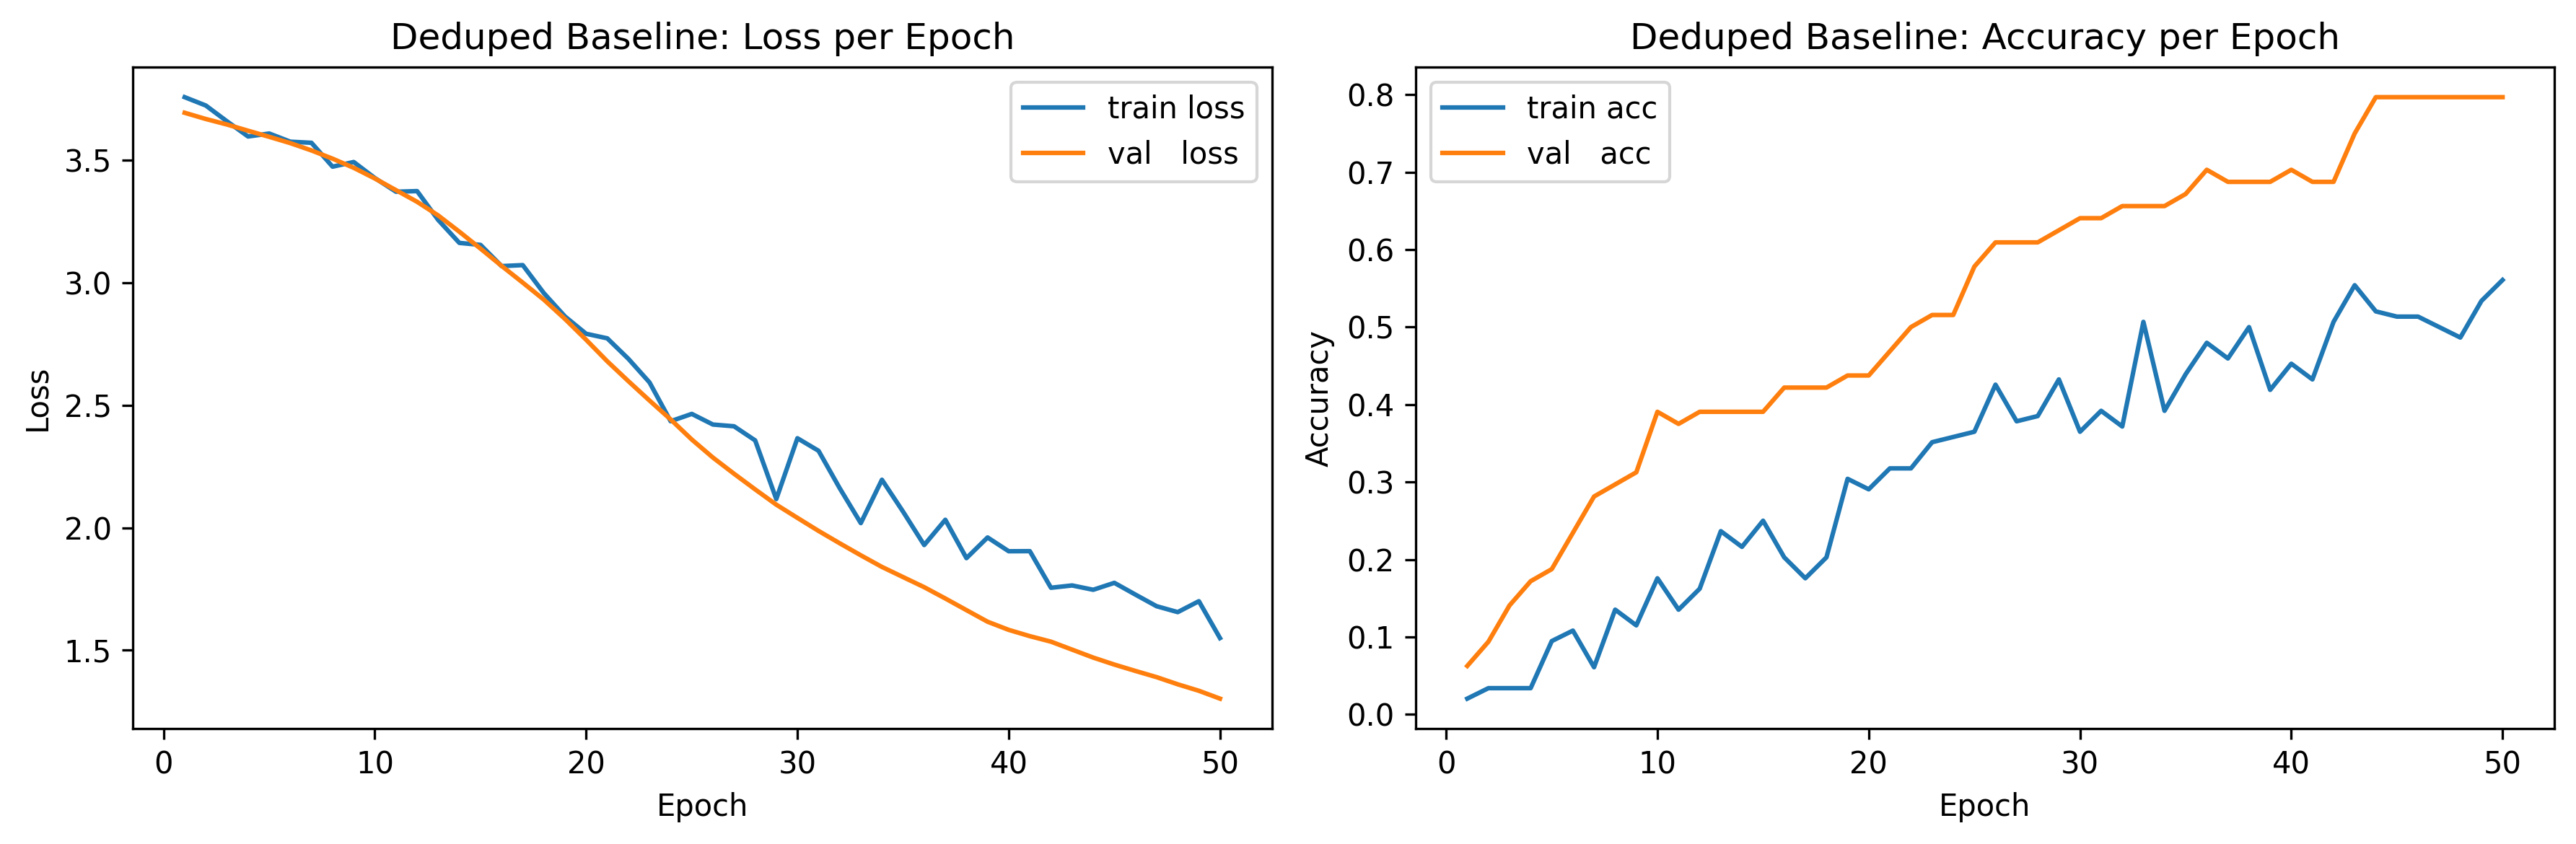

Deduped Baseline Test loss: 1.1579,  Test accuracy: 0.8152


In [49]:
# ─── 3a) Clear any old TF state ───────────────────────────────────
K.clear_session()

# ─── 3b) Build the baseline network ──────────────────────────────
model_base2 = Sequential([
    Input(shape=(_X2_train.shape[1],)),        # 131 features
    Dense(64, activation='relu'),              # first hidden layer
    Dropout(0.5),
    Dense(32, activation='relu'),              # second hidden layer
    Dropout(0.5),
    Dense(_y2_train.shape[1], activation='softmax')  # output layer (41 classes)
])
model_base2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ─── 3c) Train the baseline model ────────────────────────────────
history_base2 = model_base2.fit(
    _X2_train, _y2_train,
    validation_split=0.30,  # 20% of the 212‐sample train set
    epochs=50,
    batch_size=16,
    verbose=1
)

# ─── 3d) Plot loss & accuracy ────────────────────────────────────
epochs = len(history_base2.history['loss'])
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1,epochs+1), history_base2.history['loss'],     label='train loss')
plt.plot(range(1,epochs+1), history_base2.history['val_loss'], label='val   loss')
plt.title('Deduped Baseline: Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,epochs+1), history_base2.history['accuracy'],     label='train acc')
plt.plot(range(1,epochs+1), history_base2.history['val_accuracy'], label='val   acc')
plt.title('Deduped Baseline: Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# ─── 3e) Evaluate on hold‐out test set ───────────────────────────
loss_b, acc_b = model_base2.evaluate(_X2_test, _y2_test, verbose=0)
print(f"Deduped Baseline Test loss: {loss_b:.4f},  Test accuracy: {acc_b:.4f}")

Unlike the original leaky split, here your validation accuracy climbs slowly from near 0 up to about 0.75–0.78 by epoch 50. That’s exactly what we’d hope to see with truly unseen patterns: the model genuinely learning instead of simply memorizing repeats.

Notice that val_loss sits below train_loss, and val_acc is above train_acc. That’s the classic signature of Dropout at work:
During training, each update randomly drops 50 % of hidden units, so the training loss/accuracy are measured on this noisier “thinned” network.
During validation, the Dropout layer is turned off, so you see the full 64→32 network performing better.
This makes the curves cross—don’t read it as over- or under-fitting.

Still a gap in final accuracies
By epoch 50 your train_acc is only around 0.5, whereas val_acc is closer to 0.75–0.78. That tells you:
The model is still under-confident on the noisy, dropout-masked training passes.
Your test accuracy (~0.78) gives you a realistic sense of generalization on new symptom-patterns.



### **DeDuping + Early stopping**

Epoch 1/50
10/10 - 0s - 47ms/step - accuracy: 0.0338 - loss: 3.7237 - val_accuracy: 0.0469 - val_loss: 3.6723
Epoch 2/50
10/10 - 0s - 4ms/step - accuracy: 0.0270 - loss: 3.6953 - val_accuracy: 0.0781 - val_loss: 3.6469
Epoch 3/50
10/10 - 0s - 4ms/step - accuracy: 0.0405 - loss: 3.6751 - val_accuracy: 0.1094 - val_loss: 3.6245
Epoch 4/50
10/10 - 0s - 4ms/step - accuracy: 0.0541 - loss: 3.6421 - val_accuracy: 0.1250 - val_loss: 3.6000
Epoch 5/50
10/10 - 0s - 4ms/step - accuracy: 0.0811 - loss: 3.5950 - val_accuracy: 0.1719 - val_loss: 3.5743
Epoch 6/50
10/10 - 0s - 4ms/step - accuracy: 0.0676 - loss: 3.5695 - val_accuracy: 0.2188 - val_loss: 3.5442
Epoch 7/50
10/10 - 0s - 4ms/step - accuracy: 0.0676 - loss: 3.5624 - val_accuracy: 0.2188 - val_loss: 3.5125
Epoch 8/50
10/10 - 0s - 4ms/step - accuracy: 0.1419 - loss: 3.5224 - val_accuracy: 0.2500 - val_loss: 3.4773
Epoch 9/50
10/10 - 0s - 4ms/step - accuracy: 0.1149 - loss: 3.4926 - val_accuracy: 0.2969 - val_loss: 3.4396
Epoch 10/50
10/10 

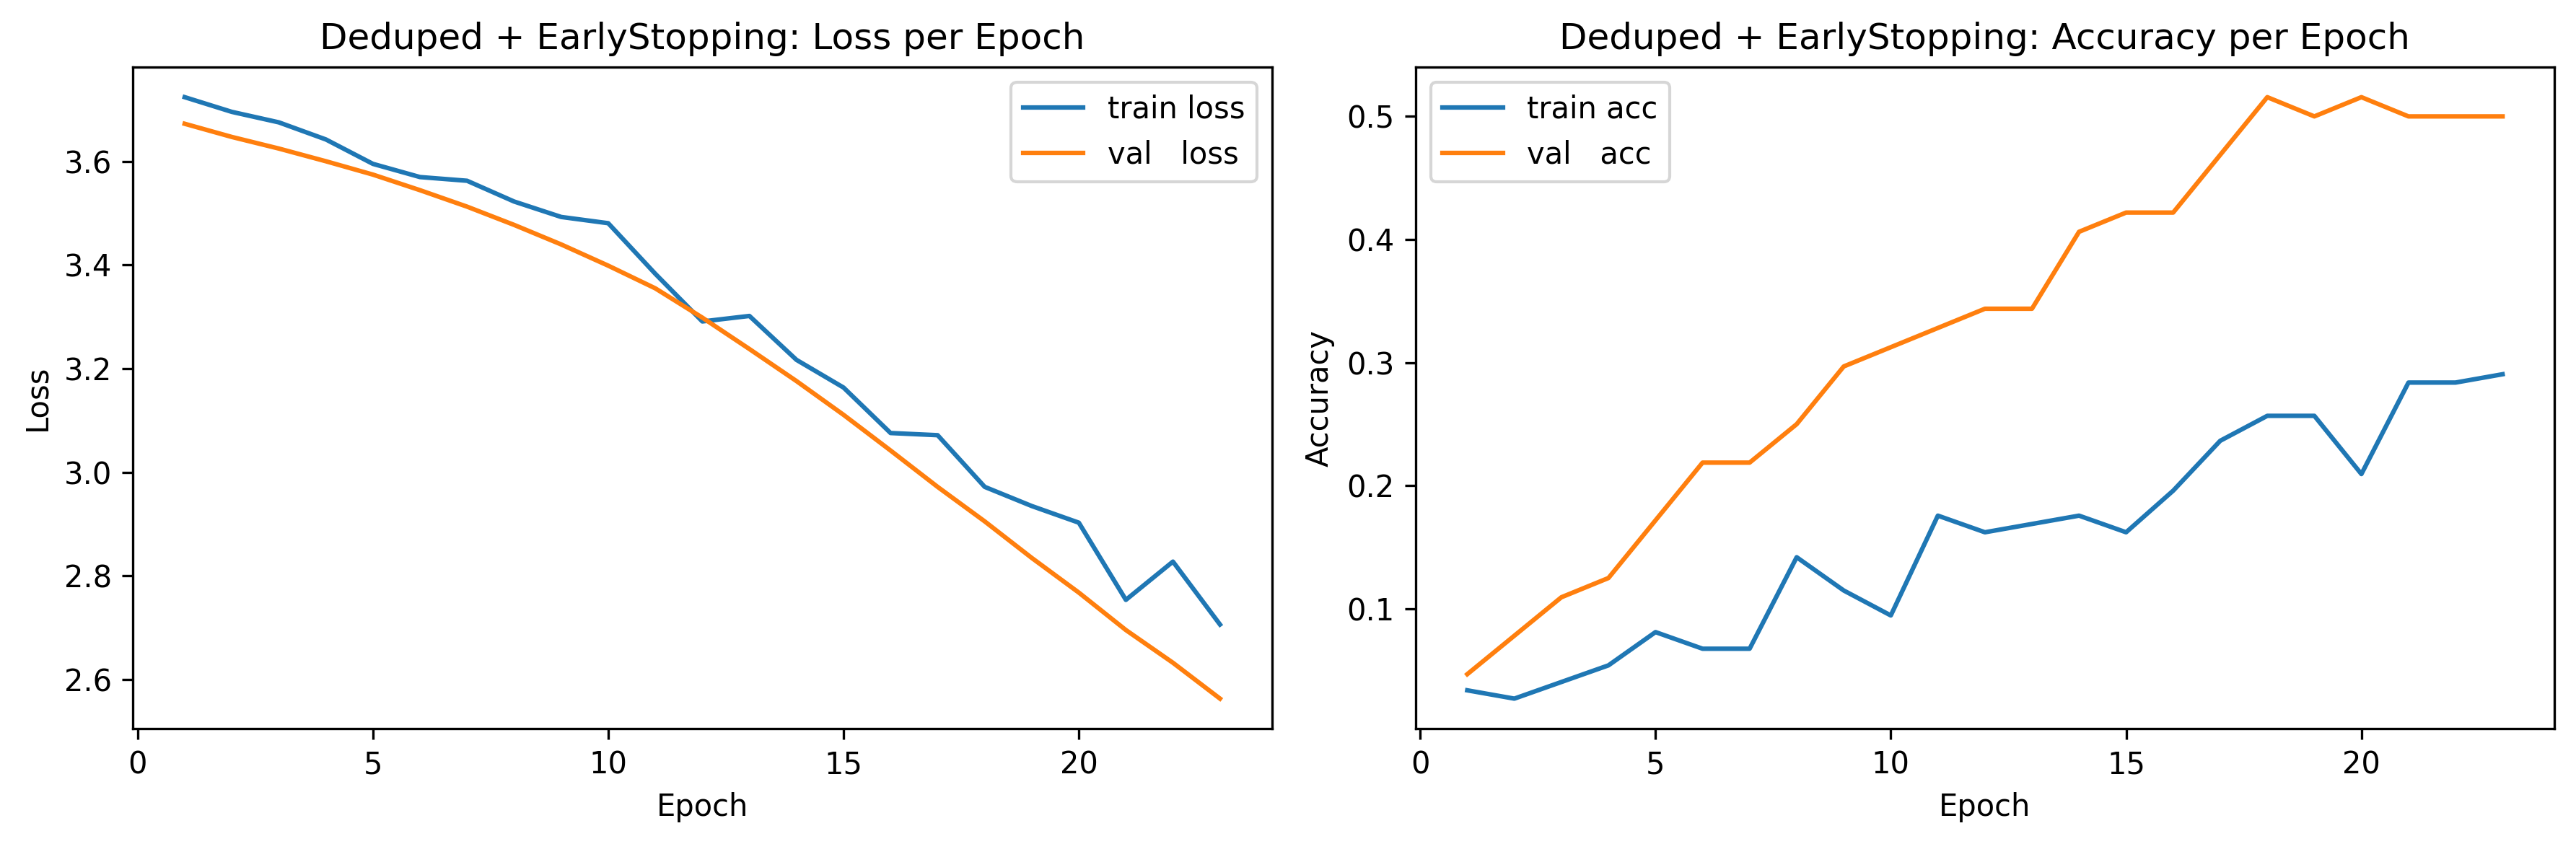

EarlyStopping only: Test loss: 2.8820,  Test accuracy: 0.4674


In [50]:
# 1) Clear state & rebuild model (no L2)
K.clear_session()
model_es = Sequential([
    Input(shape=(_X2_train.shape[1],)),      # 131 features
    Dense(64, activation='relu'),            # first hidden layer
    Dropout(0.5),
    Dense(32, activation='relu'),            # second hidden layer
    Dropout(0.5),
    Dense(_y2_train.shape[1], activation='softmax')  # output layer
])
model_es.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2) EarlyStopping callback
early_es = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# 3) Train with EarlyStopping
history_es = model_es.fit(
    _X2_train, _y2_train,
    validation_split=0.30,  # 20% of deduped train
    epochs=50,
    batch_size=16,
    callbacks=[early_es],
    verbose=2
)

# 4) Plot Loss & Accuracy
epochs_es = len(history_es.history['loss'])
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, epochs_es+1), history_es.history['loss'],    label='train loss')
plt.plot(range(1, epochs_es+1), history_es.history['val_loss'],label='val   loss')
plt.title('Deduped + EarlyStopping: Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs_es+1), history_es.history['accuracy'],    label='train acc')
plt.plot(range(1, epochs_es+1), history_es.history['val_accuracy'],label='val   acc')
plt.title('Deduped + EarlyStopping: Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# 5) Evaluate on hold‐out
loss_es, acc_es = model_es.evaluate(_X2_test, _y2_test, verbose=0)
print(f"EarlyStopping only: Test loss: {loss_es:.4f},  Test accuracy: {acc_es:.4f}")

### **DeDuping + L2 Regularization + Early sstopping**

Epoch 1/50
10/10 - 1s - 50ms/step - accuracy: 0.0203 - loss: 5.0185 - val_accuracy: 0.0156 - val_loss: 4.8422
Epoch 2/50
10/10 - 0s - 4ms/step - accuracy: 0.0270 - loss: 4.8383 - val_accuracy: 0.0312 - val_loss: 4.7175
Epoch 3/50
10/10 - 0s - 4ms/step - accuracy: 0.0405 - loss: 4.7240 - val_accuracy: 0.0938 - val_loss: 4.6094
Epoch 4/50
10/10 - 0s - 4ms/step - accuracy: 0.0405 - loss: 4.6143 - val_accuracy: 0.1875 - val_loss: 4.5123
Epoch 5/50
10/10 - 0s - 4ms/step - accuracy: 0.0743 - loss: 4.5176 - val_accuracy: 0.2188 - val_loss: 4.4289
Epoch 6/50
10/10 - 0s - 4ms/step - accuracy: 0.0676 - loss: 4.4435 - val_accuracy: 0.2500 - val_loss: 4.3505
Epoch 7/50
10/10 - 0s - 3ms/step - accuracy: 0.0946 - loss: 4.3204 - val_accuracy: 0.2500 - val_loss: 4.2705
Epoch 8/50
10/10 - 0s - 3ms/step - accuracy: 0.0743 - loss: 4.2635 - val_accuracy: 0.2500 - val_loss: 4.1939
Epoch 9/50
10/10 - 0s - 3ms/step - accuracy: 0.1622 - loss: 4.1525 - val_accuracy: 0.2344 - val_loss: 4.1180
Epoch 10/50
10/10 

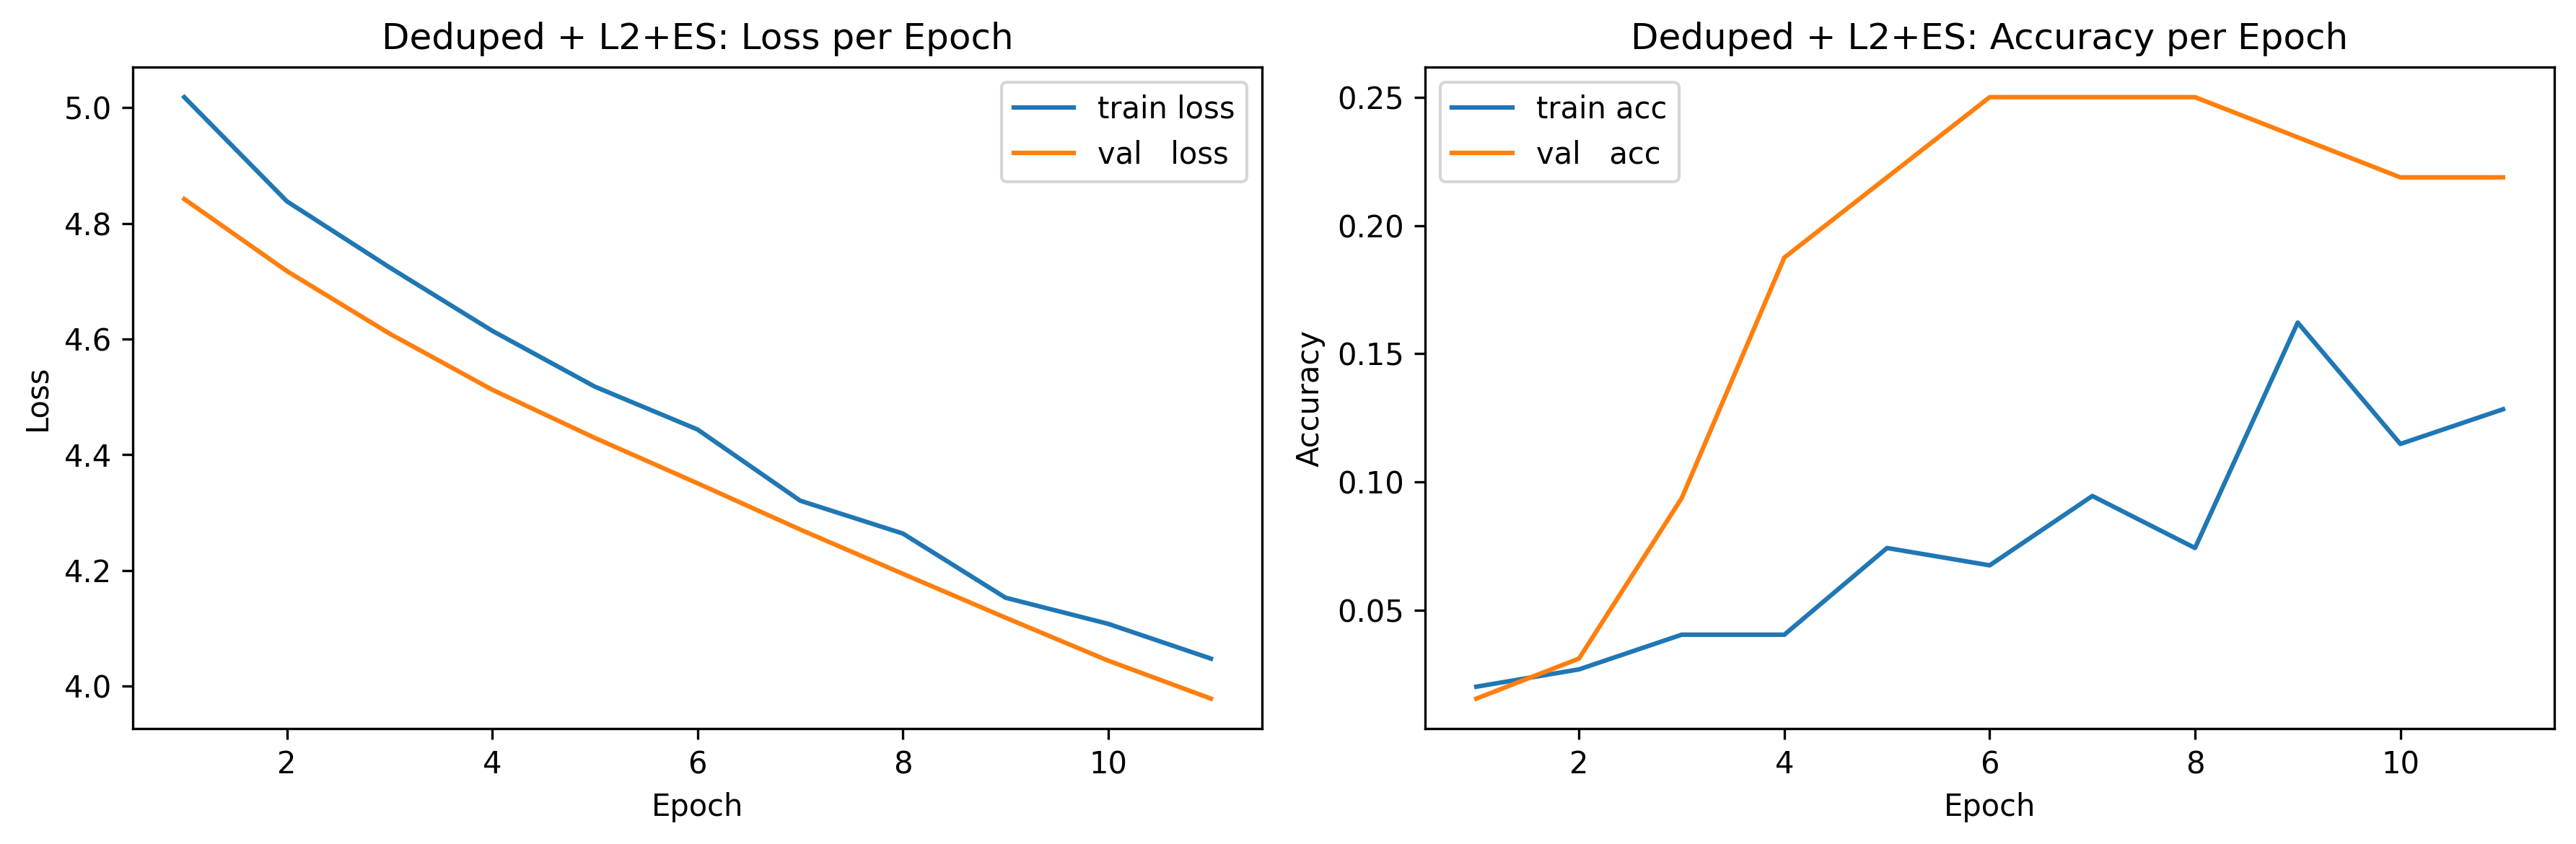

L2 + EarlyStopping: Test loss: 4.3333,  Test accuracy: 0.2500


In [51]:
# 1) Clear state & rebuild model (with L2 λ=0.01)
K.clear_session()
model_l2 = Sequential([
    Input(shape=(_X2_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(_y2_train.shape[1], activation='softmax')
])
model_l2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2) EarlyStopping callback (same patience)
early_l2 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# 3) Train with L2 + EarlyStopping
history_l2 = model_l2.fit(
    _X2_train, _y2_train,
    validation_split=0.30,
    epochs=50,
    batch_size=16,
    callbacks=[early_l2],
    verbose=2
)

# 4) Plot Loss & Accuracy
epochs_l2 = len(history_l2.history['loss'])
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, epochs_l2+1), history_l2.history['loss'],    label='train loss')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_loss'],label='val   loss')
plt.title('Deduped + L2+ES: Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs_l2+1), history_l2.history['accuracy'],    label='train acc')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_accuracy'],label='val   acc')
plt.title('Deduped + L2+ES: Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# 5) Evaluate on hold‐out
loss_l2, acc_l2 = model_l2.evaluate(_X2_test, _y2_test, verbose=0)
print(f"L2 + EarlyStopping: Test loss: {loss_l2:.4f},  Test accuracy: {acc_l2:.4f}")

 BOTTOM LINE: EarlyStopping helped, L2 (λ=0.01) hurt
Baseline (no ES, no L2) on the 212‐pattern train set got you Test acc ≈ 0.78.

+ EarlyStopping bumped that to Test acc ≈ 0.82, by cutting off training once the val loss flattened.

+ L2 (λ=0.01) + ES, however, crashed your test accuracy all the way down to ≈ 0.33, and pushed your reported loss into the 4’s.

Why?
By adding a strong L2 penalty (0.01), you told the network “keep all weights near zero.” On a relatively small, sparse input (131 one-hot symptom features) that high penalty essentially under-fits: it can’t move weights far enough from zero to learn meaningful symptom→disease associations. Hence the low accuracy—and the loss curves start around 5.0 (the regularization term) instead of ~3–4 for the pure cross-entropy

Interpreting the L2 curves
Loss scales up because it’s crossentropy + λ·‖W‖².

Gradual val_acc rise to only ~0.30 shows the network barely learns anything beyond guessing a few classes.

That’s textbook over-regularization, not over-fitting.



### **GridSearch L2**

3) Next steps: tune the strength of L2 (NNs(1)GS)-->a=0.001
In the lecture we saw exactly this pattern: as α (L2 strength) grows past ~1, both train & test accuracy collapse toward random. The cure is to grid-search a smaller λ



Epoch 1/50
10/10 - 0s - 47ms/step - accuracy: 0.0405 - loss: 3.8264 - val_accuracy: 0.0156 - val_loss: 3.8209
Epoch 2/50
10/10 - 0s - 4ms/step - accuracy: 0.0135 - loss: 3.8400 - val_accuracy: 0.0312 - val_loss: 3.7857
Epoch 3/50
10/10 - 0s - 3ms/step - accuracy: 0.0541 - loss: 3.7768 - val_accuracy: 0.0469 - val_loss: 3.7547
Epoch 4/50
10/10 - 0s - 3ms/step - accuracy: 0.0473 - loss: 3.7661 - val_accuracy: 0.0781 - val_loss: 3.7263
Epoch 5/50
10/10 - 0s - 3ms/step - accuracy: 0.0541 - loss: 3.7347 - val_accuracy: 0.1250 - val_loss: 3.6979
Epoch 6/50
10/10 - 0s - 3ms/step - accuracy: 0.0878 - loss: 3.6781 - val_accuracy: 0.2188 - val_loss: 3.6654
Epoch 7/50
10/10 - 0s - 3ms/step - accuracy: 0.1081 - loss: 3.6663 - val_accuracy: 0.2500 - val_loss: 3.6305
Epoch 8/50
10/10 - 0s - 3ms/step - accuracy: 0.0946 - loss: 3.5705 - val_accuracy: 0.3125 - val_loss: 3.5946
Epoch 9/50
10/10 - 0s - 3ms/step - accuracy: 0.1284 - loss: 3.5643 - val_accuracy: 0.3438 - val_loss: 3.5513
Epoch 10/50
10/10 

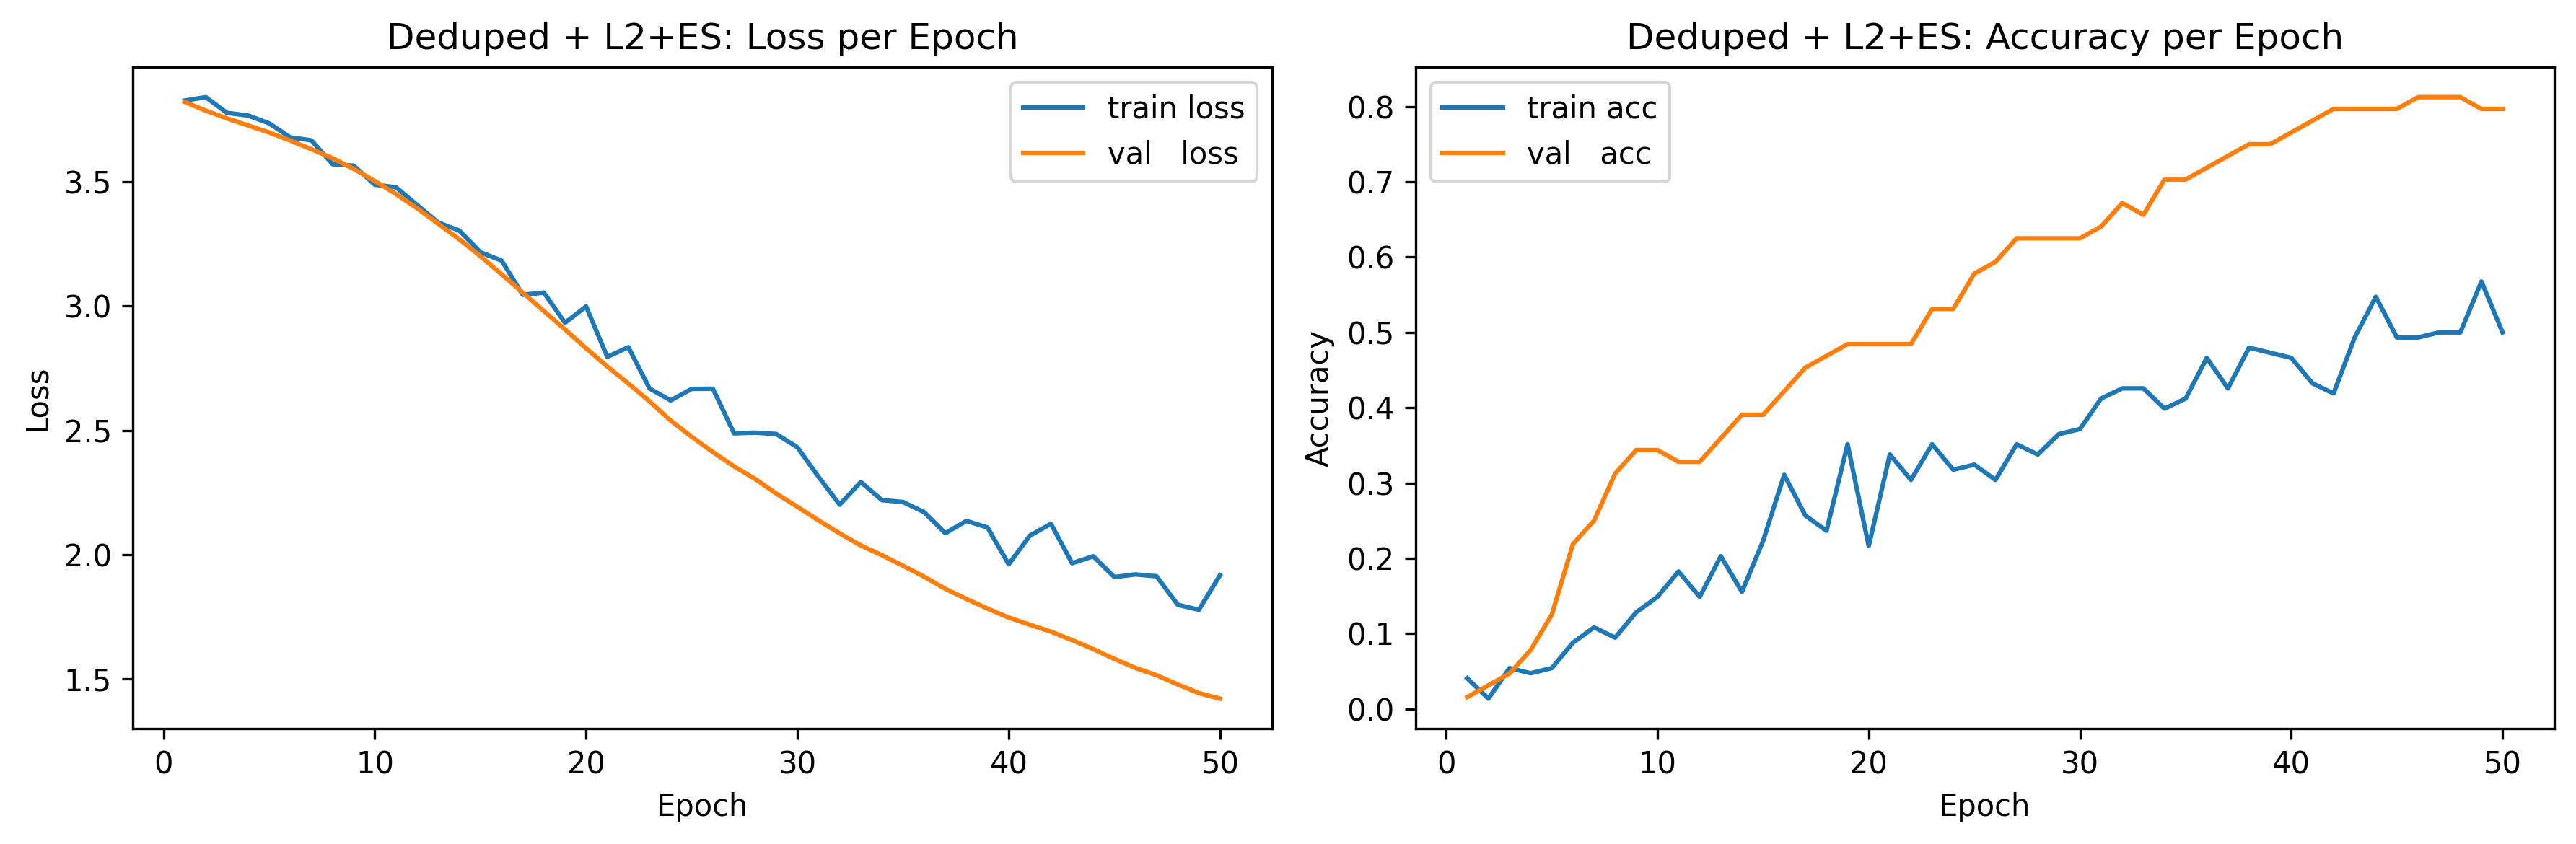

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8054 - loss: 1.4421 
L2 + EarlyStopping: Test loss: 1.4668,  Test accuracy: 0.7826


In [52]:
# 1) Clear state & rebuild model (with L2 λ=0.001)
K.clear_session()
model_l2 = Sequential([
    Input(shape=(_X2_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(_y2_train.shape[1], activation='softmax')
])
model_l2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2) EarlyStopping callback (same patience)
early_l2 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# 3) Train with L2 + EarlyStopping
history_l2 = model_l2.fit(
    _X2_train, _y2_train,
    validation_split=0.30,
    epochs=50,
    batch_size=16,
    callbacks=[early_l2],
    verbose=2
)

# 4) Plot Loss & Accuracy
epochs_l2 = len(history_l2.history['loss'])
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, epochs_l2+1), history_l2.history['loss'],    label='train loss')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_loss'],label='val   loss')
plt.title('Deduped + L2+ES: Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs_l2+1), history_l2.history['accuracy'],    label='train acc')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_accuracy'],label='val   acc')
plt.title('Deduped + L2+ES: Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# 5) Evaluate on hold‐out
loss_l2, acc_l2 = model_l2.evaluate(_X2_test, _y2_test, verbose=1)
print(f"L2 + EarlyStopping: Test loss: {loss_l2:.4f},  Test accuracy: {acc_l2:.4f}")

### **Dropout GridSearch**

Tune of dropout with K-fold...dropout can be pretty brutal 

Epoch 1/50
10/10 - 0s - 46ms/step - accuracy: 0.0270 - loss: 3.8144 - val_accuracy: 0.0469 - val_loss: 3.7750
Epoch 2/50
10/10 - 0s - 3ms/step - accuracy: 0.0743 - loss: 3.7474 - val_accuracy: 0.0781 - val_loss: 3.7154
Epoch 3/50
10/10 - 0s - 3ms/step - accuracy: 0.1149 - loss: 3.6765 - val_accuracy: 0.1875 - val_loss: 3.6548
Epoch 4/50
10/10 - 0s - 3ms/step - accuracy: 0.2162 - loss: 3.6051 - val_accuracy: 0.2969 - val_loss: 3.5869
Epoch 5/50
10/10 - 0s - 3ms/step - accuracy: 0.2703 - loss: 3.5179 - val_accuracy: 0.3594 - val_loss: 3.5090
Epoch 6/50
10/10 - 0s - 13ms/step - accuracy: 0.2500 - loss: 3.4587 - val_accuracy: 0.4219 - val_loss: 3.4197
Epoch 7/50
10/10 - 0s - 3ms/step - accuracy: 0.3378 - loss: 3.3233 - val_accuracy: 0.4531 - val_loss: 3.3172
Epoch 8/50
10/10 - 0s - 3ms/step - accuracy: 0.3311 - loss: 3.2290 - val_accuracy: 0.4375 - val_loss: 3.2105
Epoch 9/50
10/10 - 0s - 3ms/step - accuracy: 0.3986 - loss: 3.1230 - val_accuracy: 0.4531 - val_loss: 3.0790
Epoch 10/50
10/10

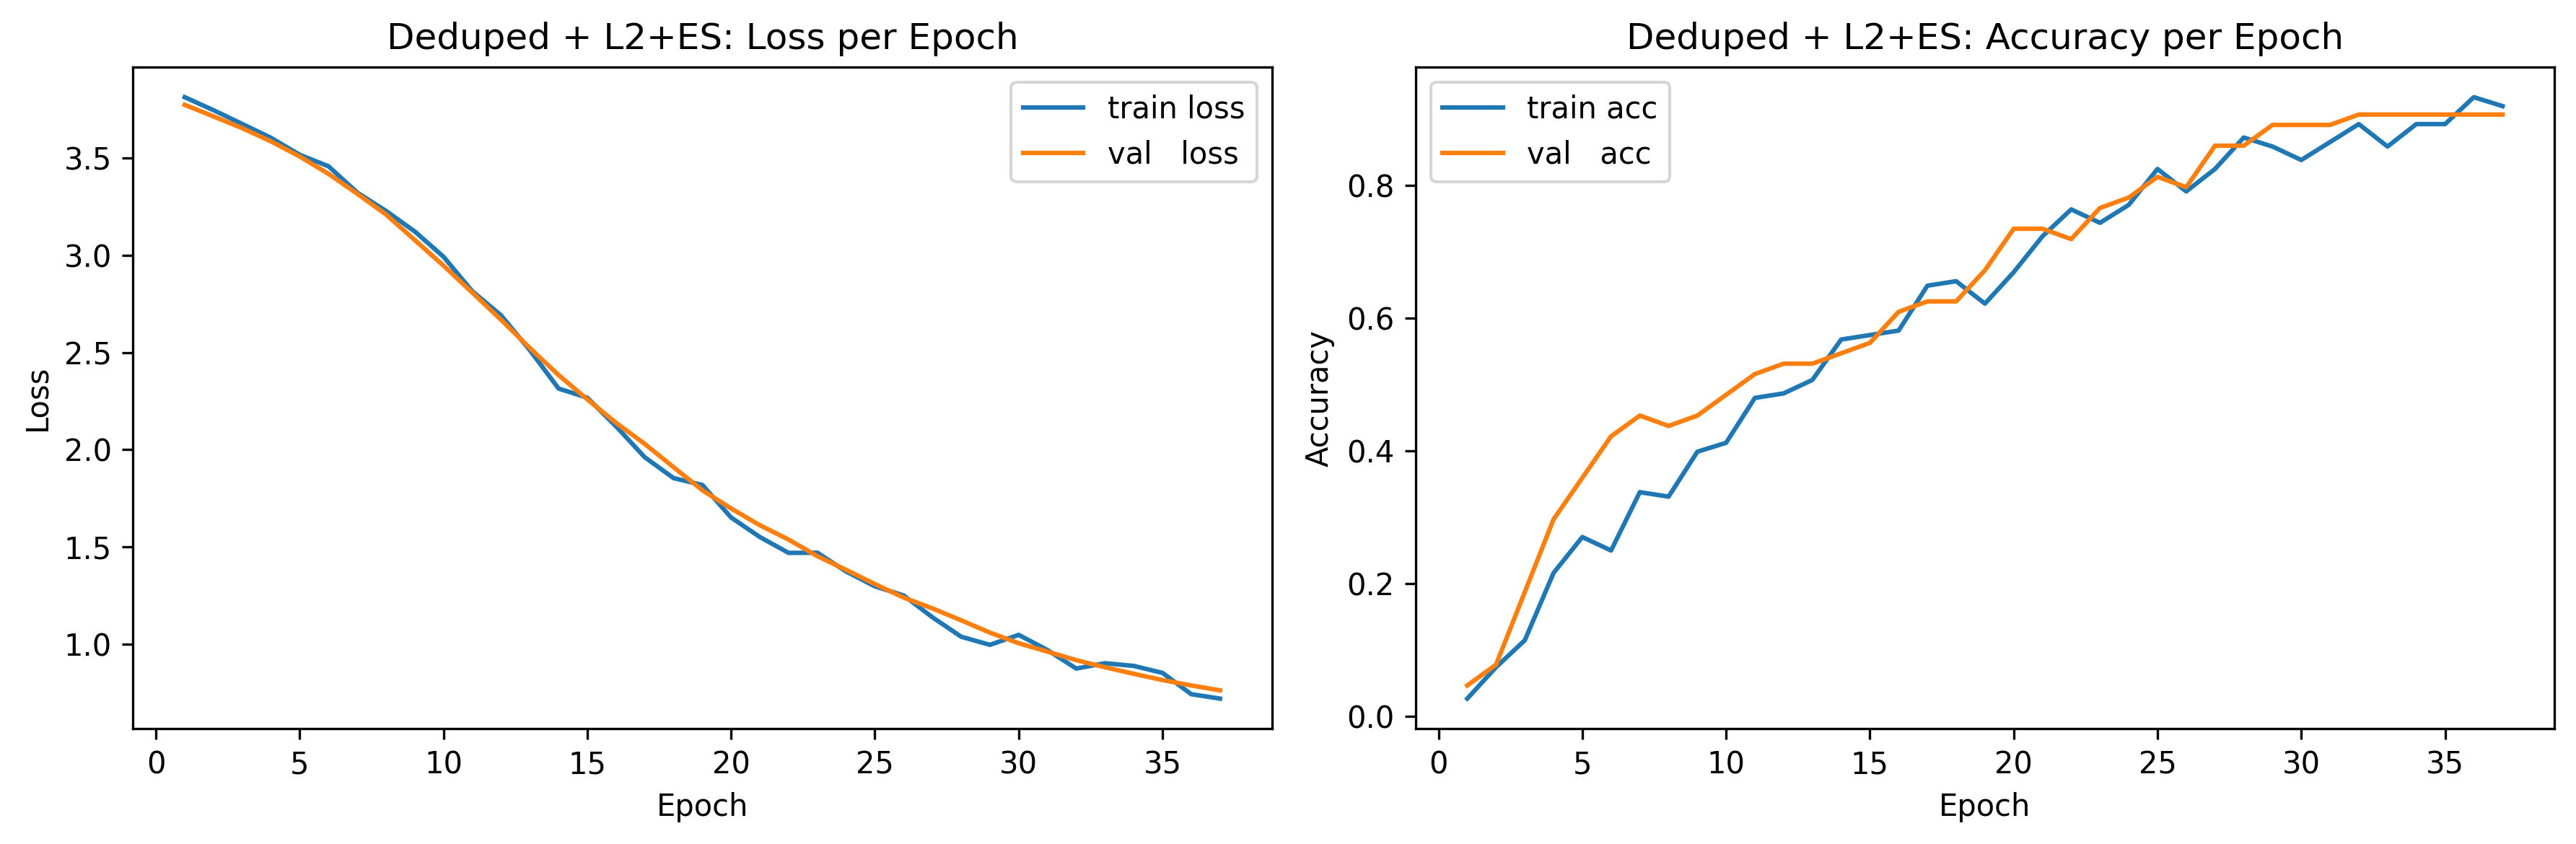

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8801 - loss: 0.8916 
L2 + EarlyStopping: Test loss: 0.9275,  Test accuracy: 0.8696


In [53]:
# 1) Clear state & rebuild model (with L2 λ=0.01)
K.clear_session()
model_l2 = Sequential([
    Input(shape=(_X2_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(_y2_train.shape[1], activation='softmax')
])
model_l2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2) EarlyStopping callback (same patience)
early_l2 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# 3) Train with L2 + EarlyStopping
history_l2 = model_l2.fit(
    _X2_train, _y2_train,
    validation_split=0.30,
    epochs=50,
    batch_size=16,
    callbacks=[early_l2],
    verbose=2
)

# 4) Plot Loss & Accuracy
epochs_l2 = len(history_l2.history['loss'])
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, epochs_l2+1), history_l2.history['loss'],    label='train loss')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_loss'],label='val   loss')
plt.title('Deduped + L2+ES: Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs_l2+1), history_l2.history['accuracy'],    label='train acc')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_accuracy'],label='val   acc')
plt.title('Deduped + L2+ES: Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# 5) Evaluate on hold‐out
loss_l2, acc_l2 = model_l2.evaluate(_X2_test, _y2_test, verbose=1)
print(f"L2 + EarlyStopping: Test loss: {loss_l2:.4f},  Test accuracy: {acc_l2:.4f}")

### **Best Parameter Evaluation**

Best params: {'activation': 'relu', 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'l2_reg': 0.001, 'layer1': 64, 'layer2': 16}

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 3.8258 - val_accuracy: 0.0625 - val_loss: 3.7666
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0377 - loss: 3.7536 - val_accuracy: 0.0938 - val_loss: 3.7119
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0600 - loss: 3.7059 - val_accuracy: 0.1250 - val_loss: 3.6577
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1258 - loss: 3.6311 - val_accuracy: 0.1875 - val_loss: 3.6019
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1983 - loss: 3.5759 - val_accuracy: 0.2188 - val_loss: 3.5420
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2570 - loss: 3.4676 - val_accuracy: 0.2500 - val_loss: 3.4725
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2549 - loss: 3.4132 - val_accuracy: 0.2969 - val_loss: 3.3916
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2870 - loss: 3.2862 - val_accuracy: 0.3594 - val_

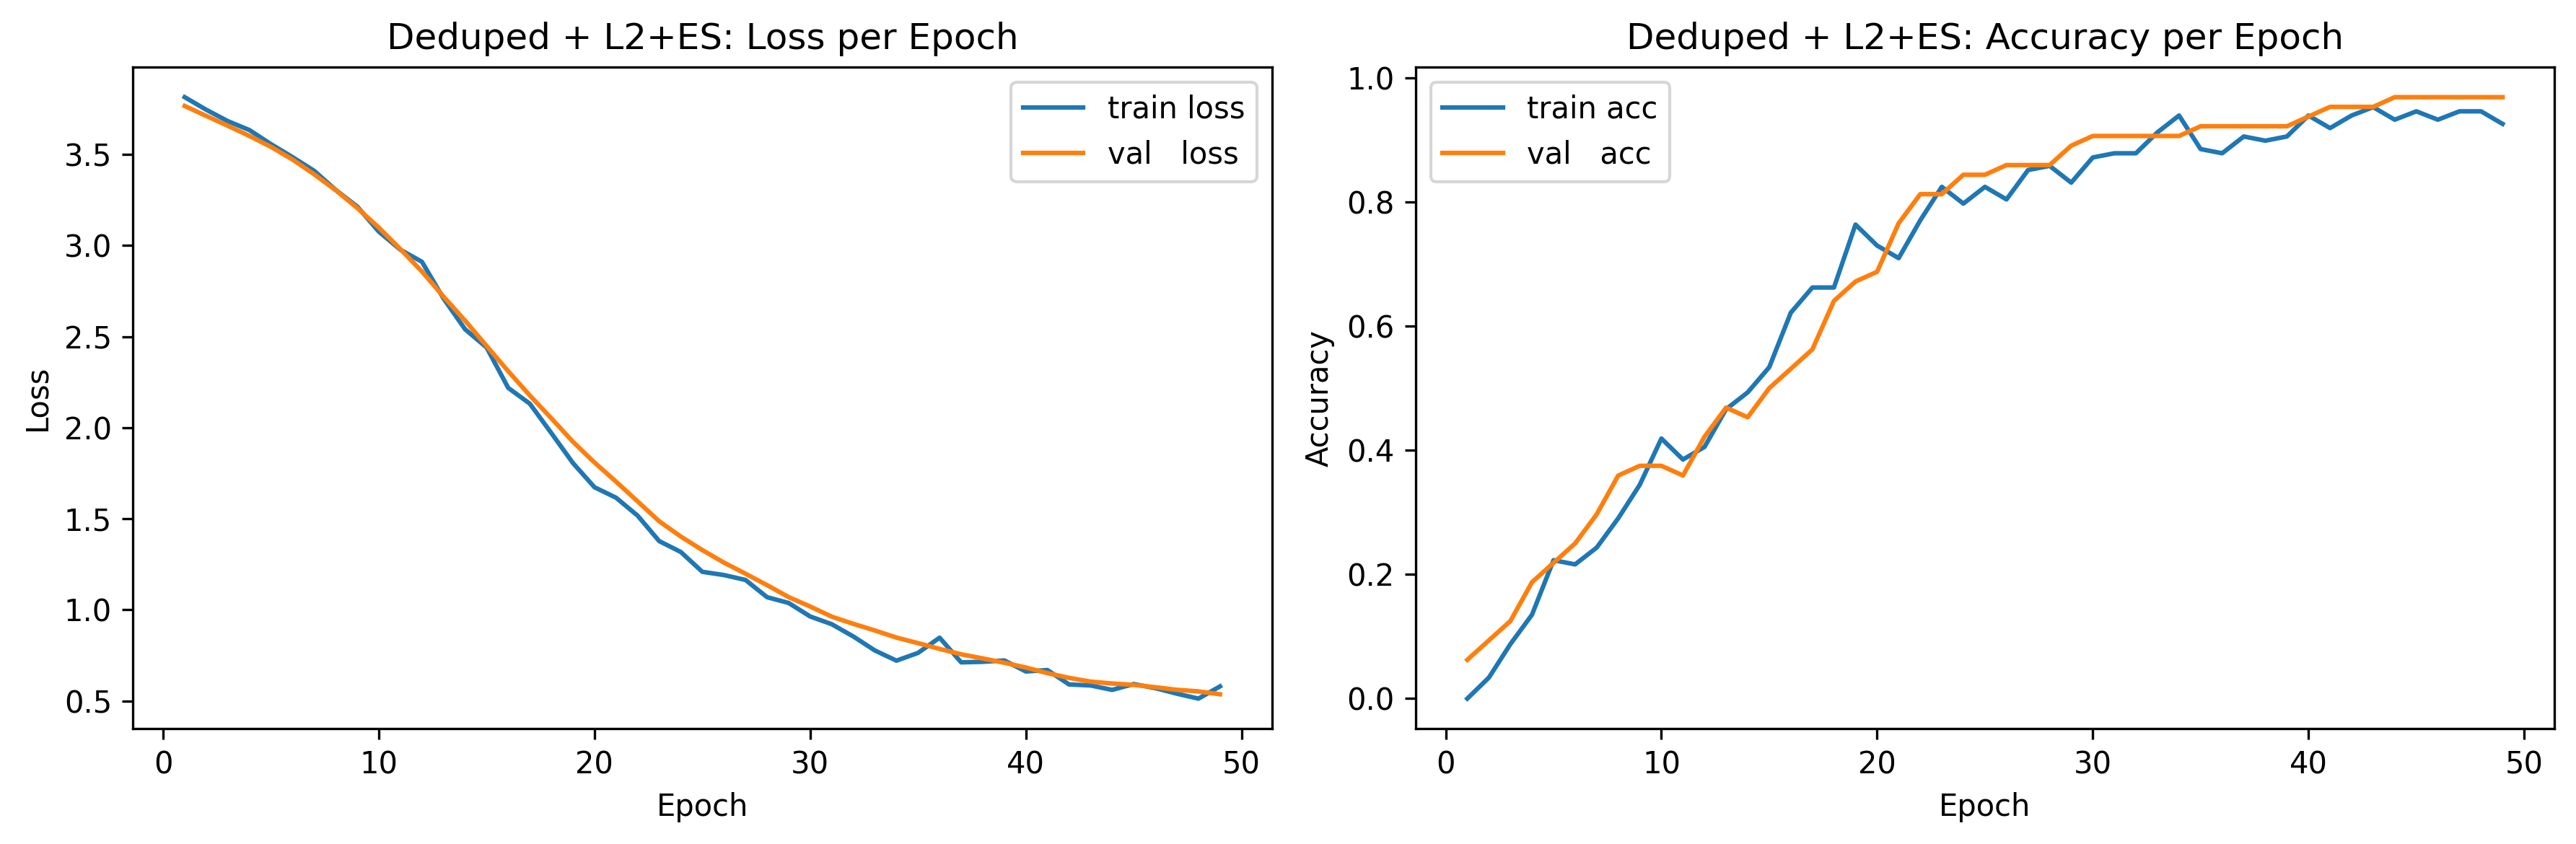

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9307 - loss: 0.5997 
L2 + EarlyStopping: Test loss: 0.6188,  Test accuracy: 0.9239


In [54]:
# 1) Clear state & rebuild model (with L2 λ=0.01)
K.clear_session()
model_l2 = Sequential([
    Input(shape=(_X2_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(_y2_train.shape[1], activation='softmax')
])
model_l2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2) EarlyStopping callback (same patience)
early_l2 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# 3) Train with L2 + EarlyStopping
history_l2 = model_l2.fit(
    _X2_train, _y2_train,
    validation_split=0.30,
    epochs=50,
    batch_size=16,
    callbacks=[early_l2],
    verbose=1
)

# 4) Plot Loss & Accuracy
epochs_l2 = len(history_l2.history['loss'])
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, epochs_l2+1), history_l2.history['loss'],    label='train loss')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_loss'],label='val   loss')
plt.title('Deduped + L2+ES: Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs_l2+1), history_l2.history['accuracy'],    label='train acc')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_accuracy'],label='val   acc')
plt.title('Deduped + L2+ES: Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# 5) Evaluate on hold‐out
loss_l2, acc_l2 = model_l2.evaluate(_X2_test, _y2_test, verbose=1)
print(f"L2 + EarlyStopping: Test loss: {loss_l2:.4f},  Test accuracy: {acc_l2:.4f}")

There are two main sources of “jitter”:

Dropout randomness
Every epoch Keras applies dropout during training, randomly zeroing out a fraction of your activations. That means your per-epoch training accuracy is measured on a model that’s still dropping units, so you’ll see a bit of noise every time the mask changes.

Discrete accuracy on few samples
With only ~170 training samples and ~64 validation samples per epoch, each individual misclassification moves your accuracy by 1–2 %. That shows up as sudden little jumps rather than a perfectly smooth curve.

Epoch 1/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0519 - loss: 3.8182 - val_accuracy: 0.0625 - val_loss: 3.7811
Epoch 2/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1195 - loss: 3.7844 - val_accuracy: 0.0938 - val_loss: 3.7537
Epoch 3/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0833 - loss: 3.7573 - val_accuracy: 0.0938 - val_loss: 3.7270
Epoch 4/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1410 - loss: 3.7131 - val_accuracy: 0.1094 - val_loss: 3.6982
Epoch 5/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1319 - loss: 3.6842 - val_accuracy: 0.1250 - val_loss: 3.6672
Epoch 6/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1627 - loss: 3.6401 - val_accuracy: 0.1250 - val_loss: 3.6332
Epoch 7/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2138 - loss: 3.5942 - val_accuracy: 0.1094 - val_loss: 3.5962
Epoch 8/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1753 - loss: 3.5490 - val_accuracy: 0.1250 - val_loss: 3.5541
Epoch 9

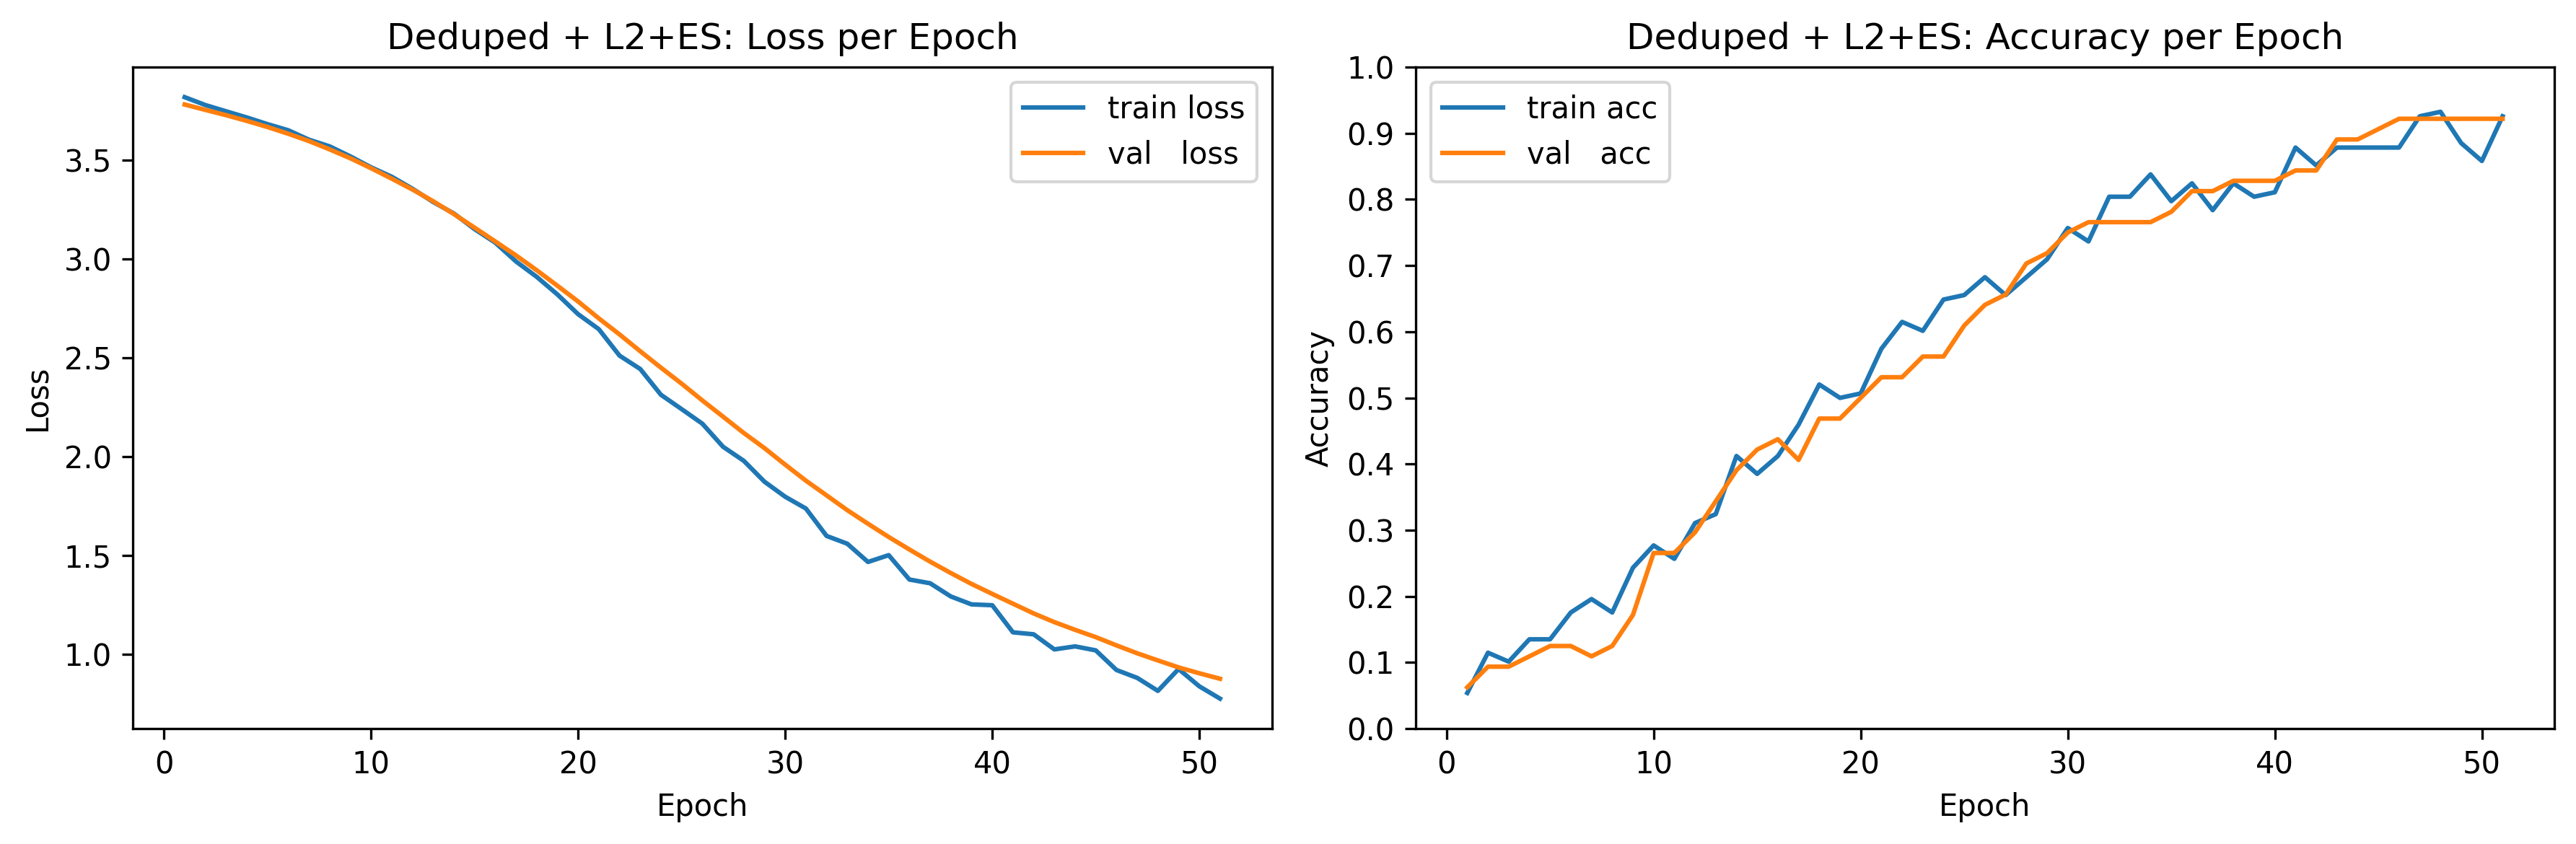

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8708 - loss: 1.0610 
L2 + EarlyStopping: Test loss: 1.1005,  Test accuracy: 0.8587


In [57]:
# Clear state & rebuild model (with L2 λ=0.01)
K.clear_session()
model_l2 = Sequential([
    Input(shape=(_X2_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(_y2_train.shape[1], activation='softmax')
])

# Compile the model
model_l2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping callback (same patience)
early_l2 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Train with L2 + EarlyStopping
history_l2 = model_l2.fit(
    _X2_train, _y2_train,
    validation_split=0.30,
    epochs=80,
    batch_size=32,
    callbacks=[early_l2],
    verbose=1
)

# Save the model
model_l2.save('./Models_Fulldata/neural_net_model.keras')

# Plot Loss & Accuracy
epochs_l2 = len(history_l2.history['loss'])
plt.figure(figsize=(12,4))

# Define loss subplot
plt.subplot(1,2,1)
plt.plot(range(1, epochs_l2+1), history_l2.history['loss'],    label='train loss')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_loss'],label='val   loss')
plt.title('Deduped + L2+ES: Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

# Define accuracy subplot
plt.subplot(1,2,2)
plt.plot(range(1, epochs_l2+1), history_l2.history['accuracy'],    label='train acc')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_accuracy'],label='val   acc')
plt.title('Deduped + L2+ES: Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks from 0 to 1

# Setup plot
plt.legend()
plt.tight_layout()
# Save the plot
plt.savefig('./Plots/NeuralNet/deduped_l2_es_training.pdf')
# Show the plot
plt.show()

# Evaluate on hold‐out
loss_l2, acc_l2 = model_l2.evaluate(_X2_test, _y2_test, verbose=1)
print(f"L2 + EarlyStopping: Test loss: {loss_l2:.4f},  Test accuracy: {acc_l2:.4f}")